# **Binary Classification with PyTorch**

In [93]:
import os
import sys 
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

In [94]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)
print("tqdm version: ", tqdm__version__)

Platform: win32
Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
---
CV2 version :  4.11.0
matplotlib version :  3.8.3
numpy version :  1.26.3
torch version :  2.5.1+cpu
torchinfo version :  1.8.0
torchvision version :  0.20.1+cpu
PIL version :  10.2.0
scikit-learn version:  1.6.1
tqdm version:  4.67.1


In [95]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


**1. Introducction**

**Goal**: To build a model for classifying a wildlife camera image into a hog or not hog.

**Objectives**
- Convert images from grayscale to RGB.
- Resize images.
- Create a transformation pipeline to standardize images for training.
- Build and train a simple neural network model in PyTorch.
- Save the trained neural network to disk.


**2. Exploring Data**

In [96]:
# Set the training path
data_dir = os.path.join("data_p1", "data_binary")
train_dir = os.path.join(data_dir, "train")

print("Data Directory:", data_dir)
print("Training Data Directory:", train_dir)

Data Directory: data_p1\data_binary
Training Data Directory: data_p1\data_binary\train


In [97]:
labels = os.listdir(train_dir)
labels

['blank', 'hog']

- The training data falls into two classes. We have either an image of a hog or an iamage where there is no animal present (blank). 
- We want our model to distinguish between these two types of images.

Determining the number of blank images in the training data and asigning the results to blank_images.

In [98]:
# Count blank images
hog_path = os.path.join(train_dir, "hog")
hog_images = os.listdir(hog_path)
print("length of hog images: ", len(hog_images))

blank_path = os.path.join(train_dir, "blank")
blank_images = os.listdir(blank_path)
print("length of blank images: ", len(blank_images))

length of hog images:  174
length of blank images:  418


Image path display:

In [99]:
hog_image_name = hog_images[0]
print(hog_image_name)

hog_image_path = os.path.join(hog_path, hog_image_name)
print(hog_image_path)

blank_image_name = blank_images[0]
print(blank_image_name)

blank_image_path = os.path.join(blank_path, blank_image_name)
print(blank_image_path)

ZJ000072.jpg
data_p1\data_binary\train\hog\ZJ000072.jpg
ZJ000061.jpg
data_p1\data_binary\train\blank\ZJ000061.jpg


Image mode and Size

In [100]:
hog_img_pil = Image.open(hog_image_path)
print("Hog image: ", hog_img_pil.mode, hog_img_pil.size)

blank_img_pil = Image.open(blank_image_path)
print("Blank image: ", blank_img_pil.mode, blank_img_pil.size)

Hog image:  L (640, 360)
Blank image:  RGB (640, 360)


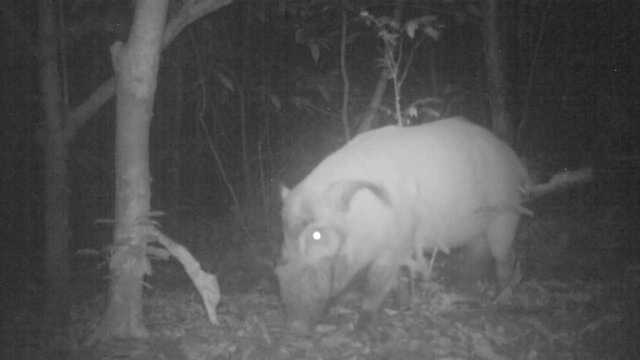

In [101]:
hog_img_pil

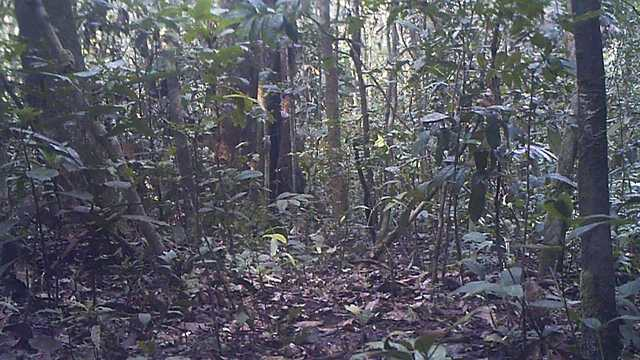

In [102]:
blank_img_pil

**3. Preparing Data**

- We need to make sure that all of our images are in the same mode. 
- We make sure that they're in RGB format. 
- We create a transformer that will convert an image to RGB mode if not.

In [103]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [104]:
# Define transformation to apply to the images
transform = transforms.Compose(
    [
        ConvertToRGB(), 
        transforms.Resize((224, 224)),
        transforms.ToTensor() # convert images to tensors
    ]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Prove binary values:

In [105]:
# Load the dataset using 'ImageFolder'
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 592
    Root location: data_p1\data_binary\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [106]:
dataset.classes

['blank', 'hog']

In [107]:
im = dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im }
print(distinct_classes)

('data_p1\\data_binary\\train\\blank\\ZJ000061.jpg', 0)
{0, 1}


In [108]:
# Validation length set
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

In [109]:
print(f"Length of training set: {len(train_dataset)}")
print(f"Length of validation set: {len(val_dataset)}")

Length of training set: 474
Length of validation set: 118


- A visualization to show the breakdown of the two classes.

In [110]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [111]:
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/474 [00:00<?, ?it/s]

blank    332
hog      142
dtype: int64

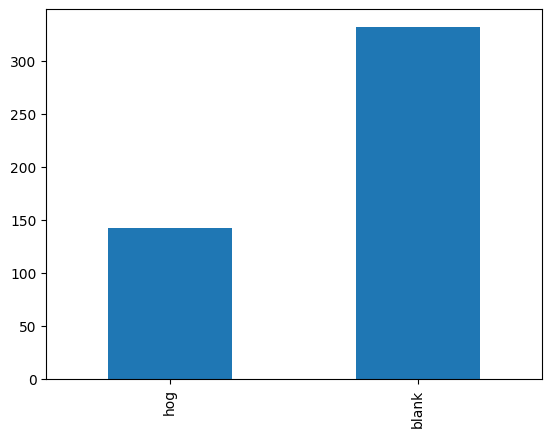

In [112]:
train_counts.sort_values().plot(kind="bar");

  0%|          | 0/118 [00:00<?, ?it/s]

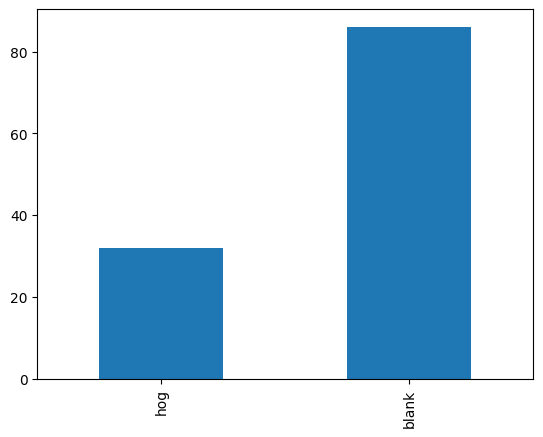

In [113]:
val_counts = class_counts(val_dataset)
val_counts
# Make a bar chart from the function output
val_counts.sort_values().plot(kind="bar");

- Creating DataLoader objects - iterables that work well with PyTorch when training. 

In [114]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=g)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


- Shape of batch images and labels.

In [115]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


In [117]:
labels

tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0])

In [118]:
images

tensor([[[[0.8549, 0.8549, 0.8549,  ..., 0.7255, 0.7216, 0.7294],
          [0.8471, 0.8471, 0.8471,  ..., 0.7216, 0.7216, 0.7294],
          [0.8392, 0.8392, 0.8392,  ..., 0.7216, 0.7216, 0.7294],
          ...,
          [0.7882, 0.7647, 0.7451,  ..., 0.9882, 0.6706, 0.7608],
          [0.8196, 0.8235, 0.8353,  ..., 0.9804, 0.8353, 0.8745],
          [0.8353, 0.8314, 0.8471,  ..., 0.9843, 0.9804, 0.9843]],

         [[0.8549, 0.8549, 0.8549,  ..., 0.7255, 0.7216, 0.7294],
          [0.8471, 0.8471, 0.8471,  ..., 0.7216, 0.7216, 0.7294],
          [0.8392, 0.8392, 0.8392,  ..., 0.7216, 0.7216, 0.7294],
          ...,
          [0.4784, 0.3961, 0.3922,  ..., 0.9882, 0.6706, 0.7608],
          [0.4667, 0.3843, 0.3882,  ..., 0.9804, 0.8353, 0.8745],
          [0.4667, 0.3608, 0.3569,  ..., 0.9843, 0.9804, 0.9843]],

         [[0.8549, 0.8549, 0.8549,  ..., 0.7255, 0.7216, 0.7294],
          [0.8471, 0.8471, 0.8471,  ..., 0.7216, 0.7216, 0.7294],
          [0.8392, 0.8392, 0.8392,  ..., 0

**4. Building a Shallow Network**

- A fully connected network with 4 layers: input layer, two hidden layers and an output layer.


<img src="full_nn_two_hidden_layers.png" alt="Shallow neural network with two hidden layers" width="800"/>

- Our input data are images. Each image is a 3D tensor. The shape is 3 x 224 x 224. But there's one problem. This neural network can't accept images in two dimensions. We need to first flatten the image.

- Convenient for us, images is already a PyTorch tensor. We determined that its shape is 32 X 3 X 224 X 224.
- The first dimension represents the number of images we have in the batch. If we flatten our images, we should get a tensor of 32 x 150528. Why 150528? It's the product of 3 X 224 X 224. 
- Each image, instead of being three dimensional, will now just have one dimension.

In [119]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)
print(tensor_flatten)

tensor([[0.8549, 0.8549, 0.8549,  ..., 0.9843, 0.9804, 0.9843],
        [0.6118, 0.6314, 0.6353,  ..., 0.9529, 0.9686, 0.9804],
        [0.2039, 0.2118, 0.2118,  ..., 0.8980, 0.9882, 0.9961],
        ...,
        [0.2471, 0.2588, 0.2667,  ..., 0.2118, 0.2039, 0.2078],
        [0.7882, 0.7961, 0.8078,  ..., 0.9725, 0.8902, 0.9451],
        [0.3843, 0.3451, 0.3020,  ..., 0.9686, 0.9608, 0.9686]])


In [120]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

# Print the shape of the flattened tensor
print(f"Shape of flattened tensor: , {tensor_flatten.shape}")

Shape of flattened tensor: , torch.Size([32, 150528])


- Flattening the images is the first step or layer of our model. 
- However, it will be tedious if we have to manually apply all the layers of our network.
- Instead, we'll use the ```nn.Sequential``` class from PyTorch. This takes a sequence of layers and runs the data throug them in order. 

In [121]:
# Image seize from our transformer
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)

print("Model type: ", type(model))
print("model structure: ")
print(model)

Model type:  <class 'torch.nn.modules.container.Sequential'>
model structure: 
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)


Output layer:

In [126]:
output_layer = nn.Linear(128, 2)
model.append(output_layer)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [143]:
model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [144]:
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─Flatten: 1-1                           [32, 150528]              --
├─Linear: 1-2                            [32, 512]                 77,070,848
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.47
Input size (MB): 19.27
Forward/backward pass size (MB): 0.16
Params size (MB): 308.55
Estimated Total Size (MB): 327.98

**5. Training Model**

In [135]:
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [136]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    # We'll report the loss function's average value at the end of the epoch.
    training_loss = 0.0

    # The train method simply sets the model in training mode. No training
    # has happened.
    model.train()

    # We iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero. We need to do this every time.
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those
        # tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # We make a forward pass through the network and obtain the logits.
        # With the logits, we can calculate our loss.
        output = model(inputs)
        loss = loss_fn(output, targets)

        # After calculating our loss, we calculate the numerical value of
        # the derivative of our loss function with respect to all the
        # trainable model weights. Once we have the gradients calculated,
        # we let the optimizer take a "step", in other words, update or
        # adjust the model weights.
        loss.backward()
        optimizer.step()

        # We increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

In [137]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/15 [00:00<?, ?it/s]

The average loss during the training epoch was 9.39.


In [139]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/15 [00:00<?, ?it/s]

The average loss during the training epoch was 0.91.


In [140]:
def predict(model, data_loader, device="cpu"):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():

        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [141]:
probabilities_train = predict(model, train_loader, device)
print(probabilities_train.shape)

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([474, 2])


In [142]:
len(train_loader.dataset)

474

In [145]:
probabilities_val = predict(model, val_loader, device)
print(probabilities_val.shape)

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([118, 2])


In [146]:
print(probabilities_train[0])

tensor([0.1115, 0.8885])


In [147]:
probabilities_train[0].sum()

tensor(1.)

In [149]:
# Print the probabilities of the first row
print(probabilities_val[0])

tensor([0.5681, 0.4319])


In [151]:
total_probability = probabilities_val[0].sum()
print(f"Sum of probabilities: {total_probability.item()}")

Sum of probabilities: 1.0


In [152]:
# cross label
predictions_train = torch.argmax(probabilities_train, dim=1)

print(f"Predictions shape: {predictions_train.shape}")
print(f"First 10 predictions: {predictions_train[:10]}")

Predictions shape: torch.Size([474])
First 10 predictions: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])


In [153]:
# Predict the most likely class label using the validation set.
predictions_val = torch.argmax(probabilities_val, dim=1)

print(f"Predictions shape: {predictions_val.shape}")
print(f"First 10 predictions: {predictions_val[:10]}")

Predictions shape: torch.Size([118])
First 10 predictions: tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1])


In [154]:
# Comapre training set to the actual class labels
targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(predictions_train, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.4388185654008439


In [155]:
# the accuracy of the model on the validation set.
targets_val = torch.cat([labels for _, labels in val_loader]).to(device)
is_correct_val = torch.eq(predictions_val, targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val = total_correct_val / len(val_loader.dataset)

print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.4915254237288136


In [156]:
def score(model, data_loader, loss_fn, device="cpu"):
    # Initialize the total loss (cross entropy) and the number of correct
    # predictions. We'll increment these values as we loop through the
    # data.
    total_loss = 0
    total_correct = 0

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # We iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # Calculating the loss function for this batch
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            # Calculating the correct predictions for this batch
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [157]:
loss_train, accuracy_train = score(model, train_loader, loss_fn, device)
print(f"Training accuracy from score function: {accuracy_train}")

Scoring:   0%|          | 0/15 [00:00<?, ?it/s]

Training accuracy from score function: 0.5569620253164557


In [158]:
loss_val, accuracy_val = score(model, val_loader, loss_fn, device)
print(f"Validation accuracy from score function: {accuracy_val}")

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy from score function: 0.4915254237288136


In [159]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

In [160]:
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device=device)

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 2.11, Validation Loss: 1.20, Validation Accuracy: 0.47


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 2.84, Validation Loss: 4.23, Validation Accuracy: 0.31


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 2.40, Validation Loss: 1.00, Validation Accuracy: 0.80


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 1.04, Validation Loss: 0.60, Validation Accuracy: 0.86


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.76, Validation Loss: 0.75, Validation Accuracy: 0.75


In [161]:

train(model, optimizer, loss_fn, train_loader, val_loader, epochs=2, device=device)

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.73, Validation Loss: 0.56, Validation Accuracy: 0.81


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.55, Validation Loss: 0.49, Validation Accuracy: 0.83


In [165]:
# prediction for each image in the validation set.
probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)
print(predictions_val[:10])

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


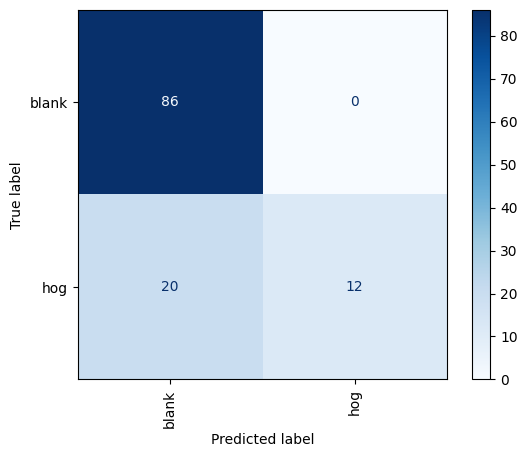

In [166]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["blank", "hog"])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

In [167]:
img_path = os.path.join(data_dir, "train/hog/ZJ000072.jpg")

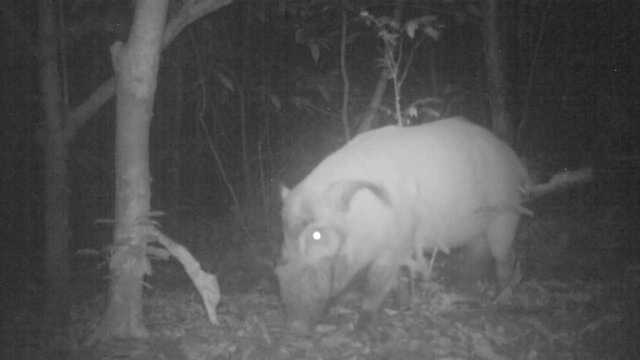

In [168]:
from IPython.display import Image as JupyterImage
JupyterImage(filename=img_path) 

In [ ]:
#pred
labels = ["blank", "hog"]

img = Image.open(os.path.join(data_dir, "train/hog/ZJ000072.jpg"))
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)

model.eval()
prediction = F.softmax(model(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction])

blank


In [171]:
F.softmax(model(img), dim=1)

tensor([[0.5180, 0.4820]], grad_fn=<SoftmaxBackward0>)

**6. Saving Model**

In [ ]:
torch.save(model, os.path.join("model", "shallownet"))
model = torch.load(os.path.join("model", "shallownet"))

In [ ]:
torch.save(model.state_dict(), os.path.join("model", "shallownet"))
new_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
)
model_state_dict = torch.load(os.path.join("model", "shallownet"))
new_model.load_state_dict(model_state_dict)